In [1]:
# Terminal commands, install rendering tools + gym
!apt-get update
!apt-get install -y xvfb x11-utils
%pip install pyvirtualdisplay==0.2.*
%pip install gym[classic_control]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:1

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
import time
from time import sleep

if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Install dependencies needed for recording videos
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

env.reset()
# Create video
for i in range(200):
  env.render()
  video.capture_frame()
  # env.action_space.sample() produces either 0 (left) or 1 (right).
  observation, reward, done,_, info = env.step(env.action_space.sample())
  # Not printing this time
  # print("step", i, observation, reward, done, info)

video.close()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:102: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  f"{self.__class__} is marked as deprecated and will be removed in the future."
/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environme

In [5]:
# Render function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [6]:
# Create and output video, BEFORE TRAINING
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

In [1]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

NameError: name 'namedtuple' is not defined

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [67]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
if gym.__version__[:4] == '0.26':
    state, _ = env.reset()
elif gym.__version__[:4] == '0.25':
    state, _ = env.reset(return_info=True)
n_observations = len(state)

policy_net100 = DQN(n_observations, n_actions).to(device)
target_net100 = DQN(n_observations, n_actions).to(device)
target_net100.load_state_dict(policy_net100.state_dict())

optimizer100 = optim.AdamW(policy_net100.parameters(), lr=LR, amsgrad=True)
memory100_train = ReplayMemory(10000)
episode_durations = []
steps_done = 0

def select_action(state,policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        #display.clear_output(wait=True)
        display.display(plt.gcf())

In [12]:
def optimize_model(memory,policy_net,target_net,optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [63]:
def train_model(num_episodes,memory,policy_net,target_net,optimizer,isRandom=False):
    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        if gym.__version__[:4] == '0.26':
            state, _ = env.reset()
        elif gym.__version__[:4] == '0.25':
            state, _ = env.reset(return_info=True)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            if isRandom  == True:
              action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
            else:
              action = select_action(state,policy_net)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(memory,policy_net,target_net,optimizer)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break
    print('Complete')
    

In [74]:
def simulate_games(policy_net,memory,video,isRandom=False):
# Each of these is its own game.
    for episode in range(5):
        if gym.__version__[:4] == '0.26':
            state, _ = env.reset()
        elif gym.__version__[:4] == '0.25':
            state, _ = env.reset(return_info=True)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            env.render()
            video.capture_frame()
            if isRandom == True:
              action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
            else:
              action = select_action(state,policy_net)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            if done:
                break
    
    video.close()
    env.close()

Complete


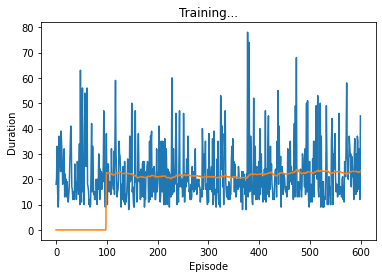

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [75]:
# Train with a RANDOM Agent

policy_netrand = DQN(n_observations, n_actions).to(device)
target_netrand = DQN(n_observations, n_actions).to(device)
target_netrand.load_state_dict(policy_net100.state_dict())

optimizerrand = optim.AdamW(policy_netrand.parameters(), lr=LR, amsgrad=True)
memoryrand_train = ReplayMemory(10000)
episode_durations = []
steps_done = 0

train_model(num_episodes=600,memory=memoryrand_train,policy_net=policy_netrand,target_net=target_netrand,optimizer=optimizerrand,isRandom=True)
plot_durations()
plt.ioff()
plt.show()

In [76]:
# Prepare environment for video
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

# Install dependencies needed for recording videos
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()
from gym.wrappers.monitoring.video_recorder import VideoRecorder
after_trainingrand = "after_trainingrand.mp4"
videorand_aftertraining = VideoRecorder(env, after_trainingrand)

memoryrand_test = ReplayMemory(10000) # create fresh memory for testing


# Simulate 5 runs after training with num_episodes = 100
simulate_games(policy_net=policy_netrand,memory=memoryrand_test,video=videorand_aftertraining,isRandom=True)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:102: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  f"{self.__class__} is marked as deprecated and will be removed in the future."
/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environme

In [77]:
# Create and output video, AFTER TRAINING RANDOM AGENT
from IPython.display import HTML
html = render_mp4(after_trainingrand)
HTML(html)

Complete


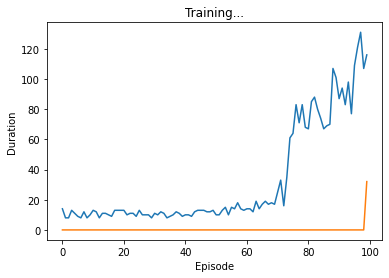

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [49]:
# Train model with a non-random agent, num_episodes = 10
episode_durations = []
train_model(num_episodes=100,memory=memory100_train,policy_net=policy_net100,target_net=target_net100,optimizer=optimizer100)
plot_durations()
plt.ioff()
plt.show()

In [53]:
# Prepare environment for video
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

# Install dependencies needed for recording videos
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()
from gym.wrappers.monitoring.video_recorder import VideoRecorder
after_training = "after_training.mp4"
video100_aftertraining = VideoRecorder(env, after_training)

memory100_test = ReplayMemory(10000) # create fresh memory for testing


# Simulate 5 runs after training with num_episodes = 100
simulate_games(policy_net=policy_net100,memory=memory100_test,video=video100_aftertraining)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:102: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  f"{self.__class__} is marked as deprecated and will be removed in the future."
/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environme

In [54]:
# Create and output video, AFTER TRAINING, n_episodes = 100
from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)

Complete


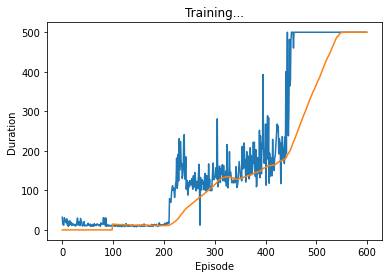

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [55]:
# Now train with num_episodes = 600

policy_net600 = DQN(n_observations, n_actions).to(device)
target_net600 = DQN(n_observations, n_actions).to(device)
target_net600.load_state_dict(policy_net100.state_dict())

optimizer600 = optim.AdamW(policy_net600.parameters(), lr=LR, amsgrad=True)
memory600_train = ReplayMemory(10000)
episode_durations = []
steps_done = 0

train_model(num_episodes=600,memory=memory600_train,policy_net=policy_net600,target_net=target_net600,optimizer=optimizer600)
plot_durations()
plt.ioff()
plt.show()

In [56]:
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

# Install dependencies needed for recording videos
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()
from gym.wrappers.monitoring.video_recorder import VideoRecorder
after_training600 = "after_training600.mp4"
video600_aftertraining = VideoRecorder(env, after_training600)

memory600_test = ReplayMemory(10000) # create fresh memory for testing


# Simulate 5 runs after training with num_episodes = 100
simulate_games(policy_net=policy_net600,memory=memory600_test,video=video600_aftertraining)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:102: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  f"{self.__class__} is marked as deprecated and will be removed in the future."
/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environme

In [57]:
# Create and output video, AFTER TRAINING
from IPython.display import HTML
html = render_mp4(after_training600)
HTML(html)